In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# Importing modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder, LabelEncoder,
                                   OrdinalEncoder,
                                   PolynomialFeatures)

# Data Loading
This part loads the dataset and displays the first few rows to understand the structure of the data.

In [4]:
train_data = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test_data = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [5]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (100000, 76)
Test Data Shape: (10000, 75)


In [6]:
print("\nTrain Data Head:")
print(train_data.head())


Train Data Head:
                          MachineID   ProductName EngineVersion  \
0  f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1  dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2  fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3  38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4  32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   

         AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0   4.18.1807.18075     1.275.1003.0           0                      7.0   
1   4.18.1807.18075     1.273.1465.0           0                      7.0   
2   4.18.1807.18075     1.275.1546.0           0                      7.0   
3  4.12.17007.18011     1.275.1141.0           0                      7.0   
4    4.13.17134.228     1.275.1283.0           0                      7.0   

   IsPassiveModeEnabled  AntivirusConfigID  NumAntivirusProductsInstalled  \
0                     0            5344

# Exploratory Data Analysis [EDA]
Here, we perform statistical analysis and visualize key trends to understand the dataset.

In [7]:
print("\nTrain Data Information:")
print(train_data.info())


Train Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  Ha

In [8]:
print("\nTrain Data Description:")
print(train_data.describe())


Train Data Description:
       IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%     

In [9]:
print("\nTrain Data Data-Types:")
print(train_data.dtypes)


Train Data Data-Types:
MachineID            object
ProductName          object
EngineVersion        object
AppVersion           object
SignatureVersion     object
                     ...   
IsGamer             float64
RegionIdentifier    float64
DateAS               object
DateOS               object
target                int64
Length: 76, dtype: object


# Handling Missing Data
We check for the null values, and drop the less related features and apply appropriate imputation techniques .

In [10]:
print("\nTrain Data Missing Values:")
print(train_data.isnull().sum())
test_data.isnull().sum().sum()


Train Data Missing Values:
MachineID             0
ProductName           0
EngineVersion         0
AppVersion            0
SignatureVersion      0
                   ... 
IsGamer             559
RegionIdentifier    559
DateAS                0
DateOS               24
target                0
Length: 76, dtype: int64


633

In [11]:
train_data.drop(['MachineID','IsBetaUser',
    'IsPassiveModeEnabled','NumAntivirusProductsInstalled',
    'AutoSampleSubmissionEnabled','CityID','InternalBatteryNumberOfCharges',
    'NumericOSVersion','OSBranch','OSBuildNumberOnly',
    'OSBuildRevisionOnly','OSSkuFriendlyName','OSInstallType','OSInstallLanguageID',
    'OSUILocaleID','IsPortableOS', 'FirmwareManufacturerID',
    'EnableLUA','LocaleEnglishNameID','OSBuildNumber','IsFlightsDisabled',
    'IsPortableOS','OsPlatformSubRelease','SMode','PowerPlatformRole',
    'IsTouchEnabled','MDC2FormFactor','DeviceFamily','PrimaryDiskCapacityMB',
    'IsPenCapable','OEMNameID','OEMModelID','ProcessorManufacturerID','ProcessorModelID',
    'DateAS','ChassisType','PrimaryDisplayDiagonalInches','PrimaryDisplayResolutionHorizontal',
    'PrimaryDisplayResolutionVertical', 'IsGamer','RegionIdentifier'], axis=1, inplace=True)
test_data.drop(['MachineID','IsBetaUser',
    'IsPassiveModeEnabled','NumAntivirusProductsInstalled',
    'AutoSampleSubmissionEnabled','CityID','InternalBatteryNumberOfCharges',
    'NumericOSVersion','OSBranch','OSBuildNumberOnly',
    'OSBuildRevisionOnly','OSSkuFriendlyName','OSInstallType','OSInstallLanguageID',
    'OSUILocaleID','IsPortableOS', 'FirmwareManufacturerID','IsFlightsDisabled',
    'EnableLUA','LocaleEnglishNameID','OSBuildNumber',
    'IsPortableOS','OsPlatformSubRelease','SMode','PowerPlatformRole',
    'IsTouchEnabled','MDC2FormFactor','DeviceFamily','PrimaryDiskCapacityMB',
    'IsPenCapable','OEMNameID','OEMModelID','ProcessorManufacturerID','ProcessorModelID',
    'DateAS','ChassisType','PrimaryDisplayDiagonalInches','PrimaryDisplayResolutionHorizontal',
    'PrimaryDisplayResolutionVertical', 'IsGamer','RegionIdentifier'], axis=1, inplace=True)

In [12]:
train_data.fillna(train_data.median(numeric_only=True),inplace=True)
test_data.fillna(test_data.median(numeric_only=True),inplace = True)
train_data.dropna()
test_data.dropna()

,ProductName,EngineVersion,AppVersion,SignatureVersion,RealTimeProtectionState,AntivirusConfigID,NumAntivirusProductsEnabled,HasTpm,CountryID,GeoRegionID,...,OSEdition,AutoUpdateOptionsName,OSGenuineState,LicenseActivationChannel,FlightRing,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsAlwaysOnAlwaysConnectedCapable,DateOS
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1276.0,7.0,53447.0,1.0,1,218,224.0,...,Professional,FullAuto,INVALID_LICENSE,Retail,Retail,48751.0,0,0.0,0.0,2018-07-10
1,win8defender,1.1.15100.1,4.10.209.0,1.273.371.0,7.0,46184.0,2.0,1,68,276.0,...,Core,FullAuto,IS_GENUINE,Retail,Retail,64709.0,1,0.0,0.0,2016-10-11
2,win8defender,1.1.15200.1,4.18.1807.18075,1.275.263.0,7.0,51954.0,1.0,1,141,167.0,...,CoreSingleLanguage,Notify,IS_GENUINE,OEM:DM,Retail,33094.0,1,0.0,0.0,2018-05-08
3,win8defender,1.1.15300.6,4.18.1807.18075,1.277.58.0,7.0,41571.0,1.0,1,41,240.0,...,CoreSingleLanguage,Notify,IS_GENUINE,OEM:DM,Retail,26184.0,1,0.0,0.0,2018-05-08
4,win8defender,1.1.14800.3,4.14.17639.18041,1.267.898.0,7.0,40645.0,1.0,1,43,53.0,...,Professional,Notify,IS_GENUINE,Retail,Unknown,12126.0,0,0.0,0.0,2018-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1329.0,7.0,32554.0,1.0,1,207,277.0,...,Core,FullAuto,IS_GENUINE,OEM:DM,Unknown,20107.0,0,0.0,0.0,2018-09-11
9996,win8defender,1.1.15100.1,4.11.15063.0,1.273.894.0,7.0,53447.0,1.0,1,214,277.0,...,Professional,UNKNOWN,IS_GENUINE,Volume:GVLK,Retail,11386.0,0,0.0,0.0,2017-04-05
9997,win8defender,1.1.15200.1,4.18.1807.18075,1.275.504.0,7.0,47238.0,1.0,1,91,125.0,...,Core,UNKNOWN,IS_GENUINE,OEM:DM,Retail,12247.0,1,0.0,0.0,2018-06-12
9998,win8defender,1.1.15200.1,4.18.1807.18075,1.275.461.0,7.0,53447.0,1.0,1,9,10.0,...,CoreSingleLanguage,UNKNOWN,IS_GENUINE,OEM:DM,Retail,4269.0,1,0.0,0.0,2017-12-12


# Conversion
The versions given are in 'Object' data type which are not in a format for the model to understand the feature. So, we are converting them into a numerical feature. 

In [13]:
def process_version(value):
    
    if pd.isnull(value):  
        return None

    try:
        parts = value.split('.')
        if len(parts) != 4:
            return None  

        major, minor, build, rev = map(int, parts)

        wt_major = major * 1000000
        wt_minor = minor * 10000
        wt_build = build * 100
        wt_rev = rev

        sumation = wt_major + wt_minor + wt_build + wt_rev
        return sumation

    except (ValueError, AttributeError): 
        return None  

train_data['AppVerNum'] = train_data['AppVersion'].apply(process_version)
print(train_data[['AppVersion', 'AppVerNum']].head())

         AppVersion  AppVerNum
0   4.18.1807.18075    4378775
1   4.18.1807.18075    4378775
2   4.18.1807.18075    4378775
3  4.12.17007.18011    5838711
4    4.13.17134.228    5843628


In [14]:
train_data['EngineVerNum'] = train_data['EngineVersion'].apply(process_version)
train_data['SigVerNum']= train_data['SignatureVersion'].apply(process_version)

In [15]:
test_data['EngineVerNum'] = test_data['EngineVersion'].apply(process_version)
test_data['SigVerNum']= test_data['SignatureVersion'].apply(process_version)
test_data['AppVerNum'] = test_data['AppVersion'].apply(process_version)

In [16]:
train_data.drop(['AppVersion','SignatureVersion','EngineVersion'], axis=1, inplace=True)
test_data.drop(['AppVersion','SignatureVersion','EngineVersion'], axis=1, inplace=True)

# Encoding Categorical Features

In [17]:
categorical_cols = train_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    train_data[col] = LabelEncoder().fit_transform(train_data[col].astype(str))
    test_data[col] = LabelEncoder().fit_transform(test_data[col].astype(str))

In [18]:
print(categorical_cols)

Index(['ProductName', 'PlatformType', 'Processor', 'OSVersion', 'OSBuildLab',
       'SKUEditionName', 'PrimaryDiskType', 'OSArchitecture', 'OSEdition',
       'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel',
       'FlightRing', 'DateOS'],
      dtype='object')


In [19]:
print("Null values in Train data :",train_data.isnull().sum().sum())
print("Null values in Test data :",test_data.isnull().sum().sum())

Null values in Train data : 0
Null values in Test data : 0


# DATA VISUALIZATION
Visualizing the key statistics among the numerical and categorical features

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

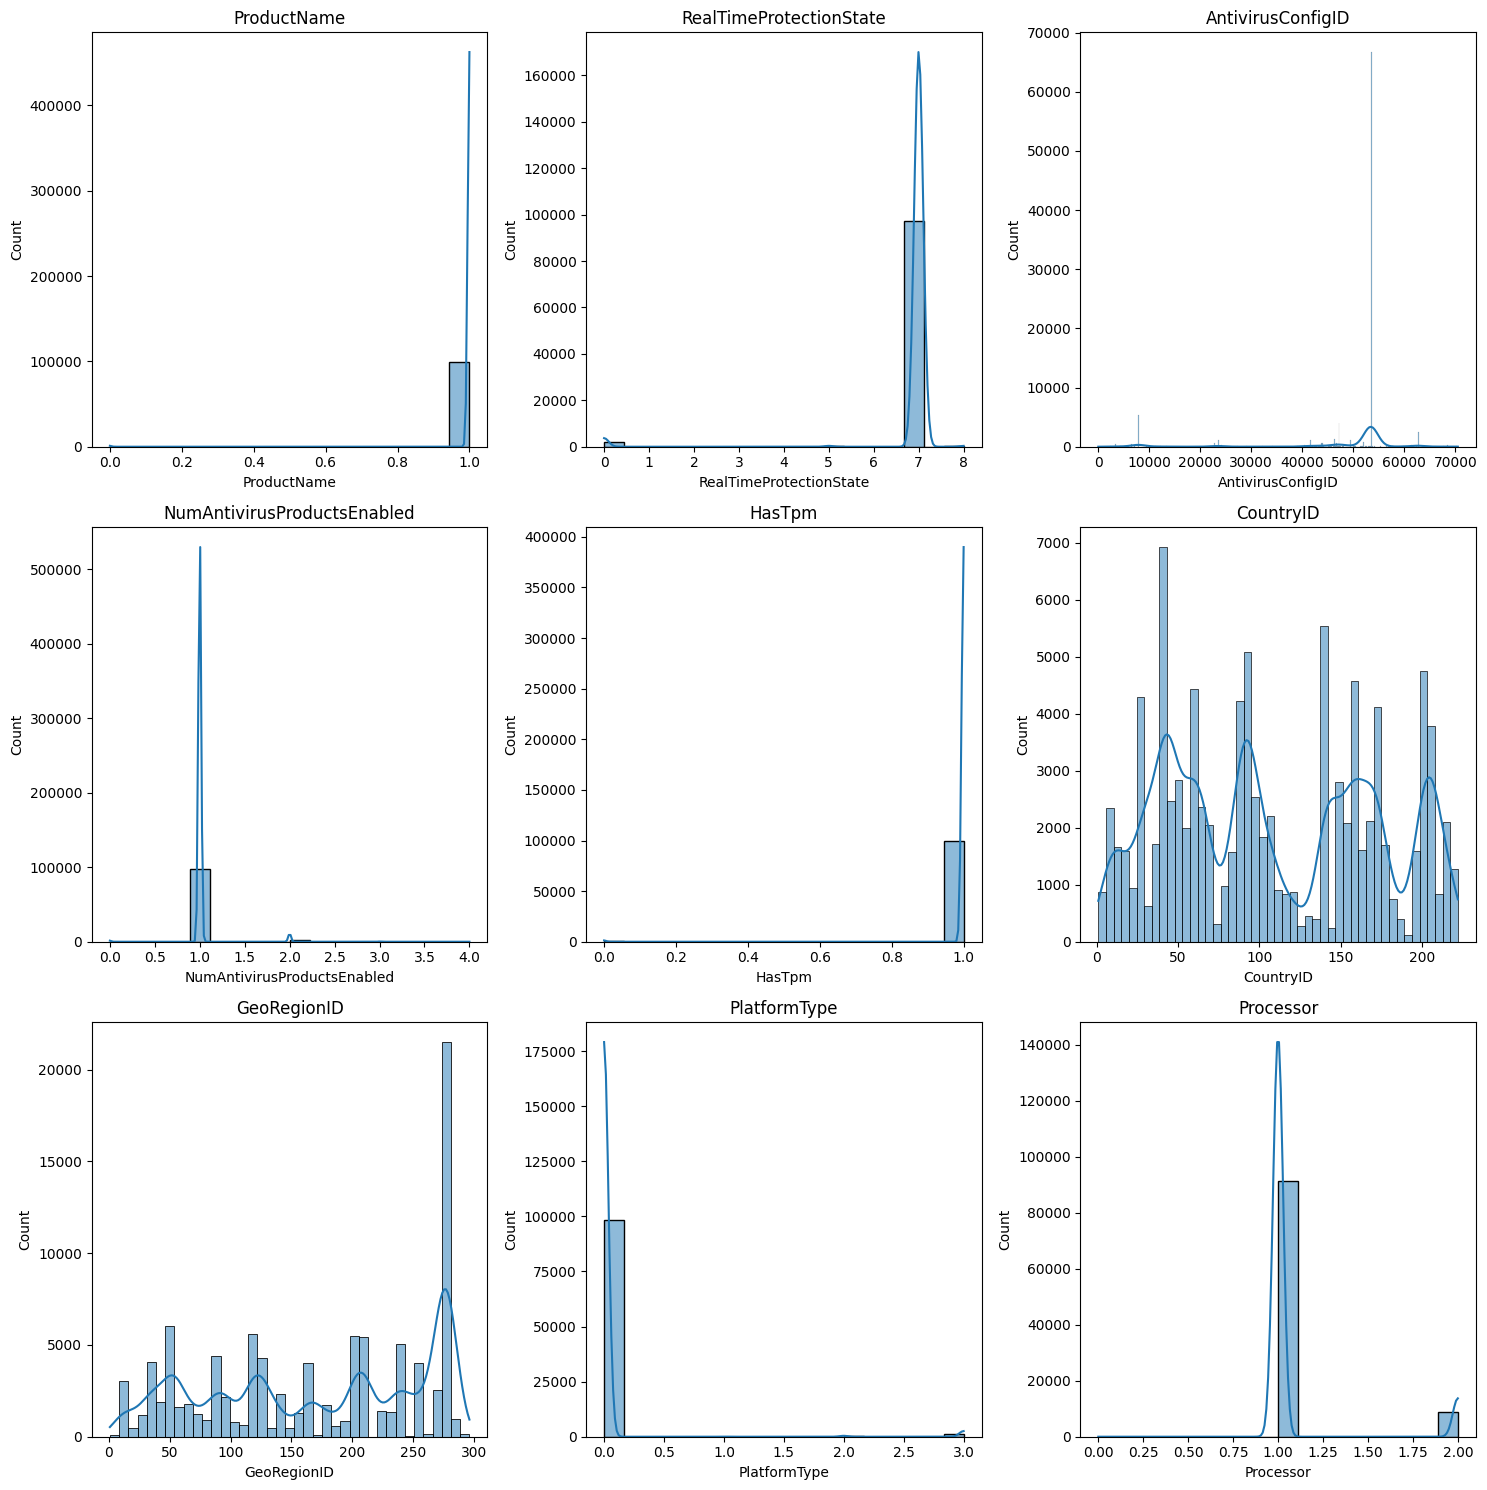

In [20]:
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
fig, ax = plt.subplots(3,3,figsize=(15,15))
for i ,subplot in zip(numerical_cols, ax.flatten()):
    sns.histplot(train_data[i],ax=subplot, kde=True)
    subplot.set_title(i)
plt.tight_layout()
plt.show()

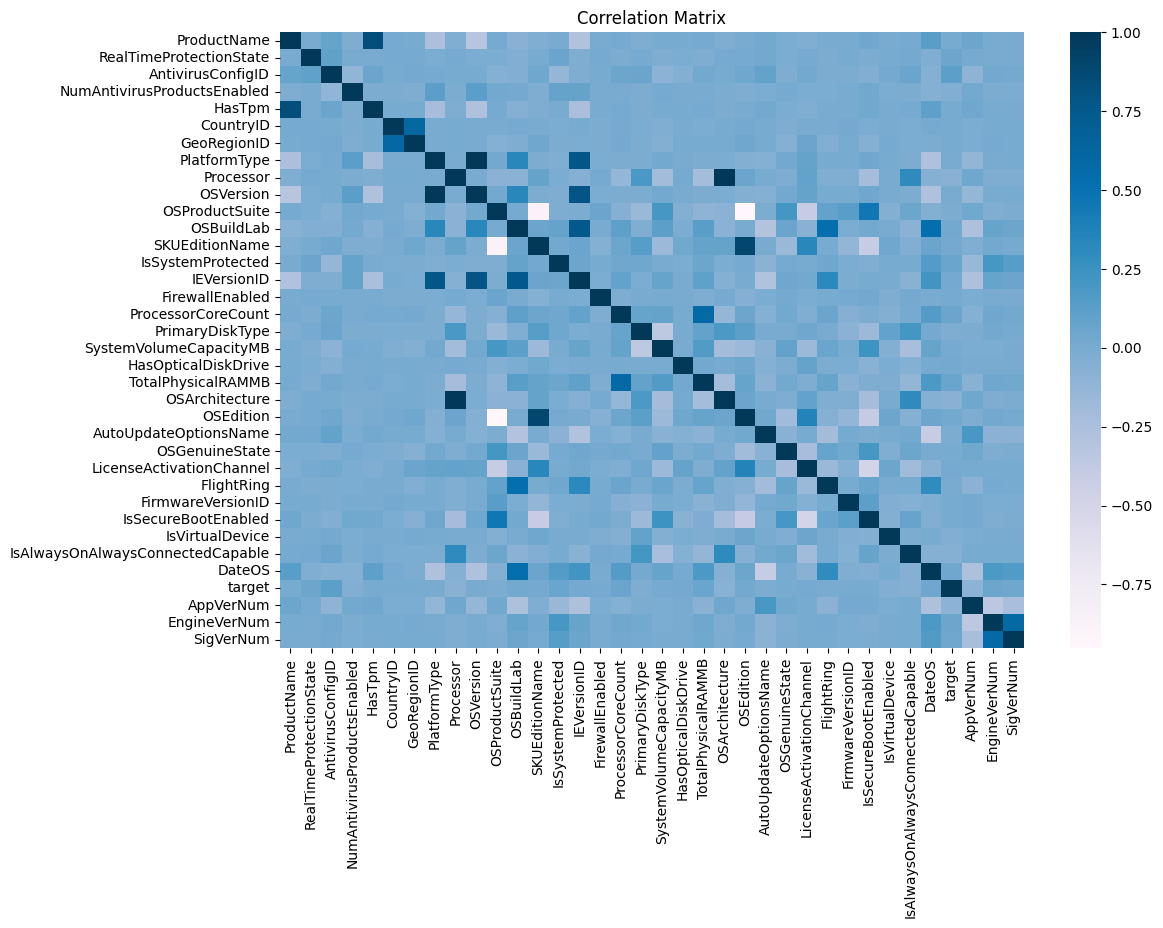

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(train_data[numerical_cols].corr(), annot=False, cmap='PuBu')
plt.title('Correlation Matrix')
plt.show()

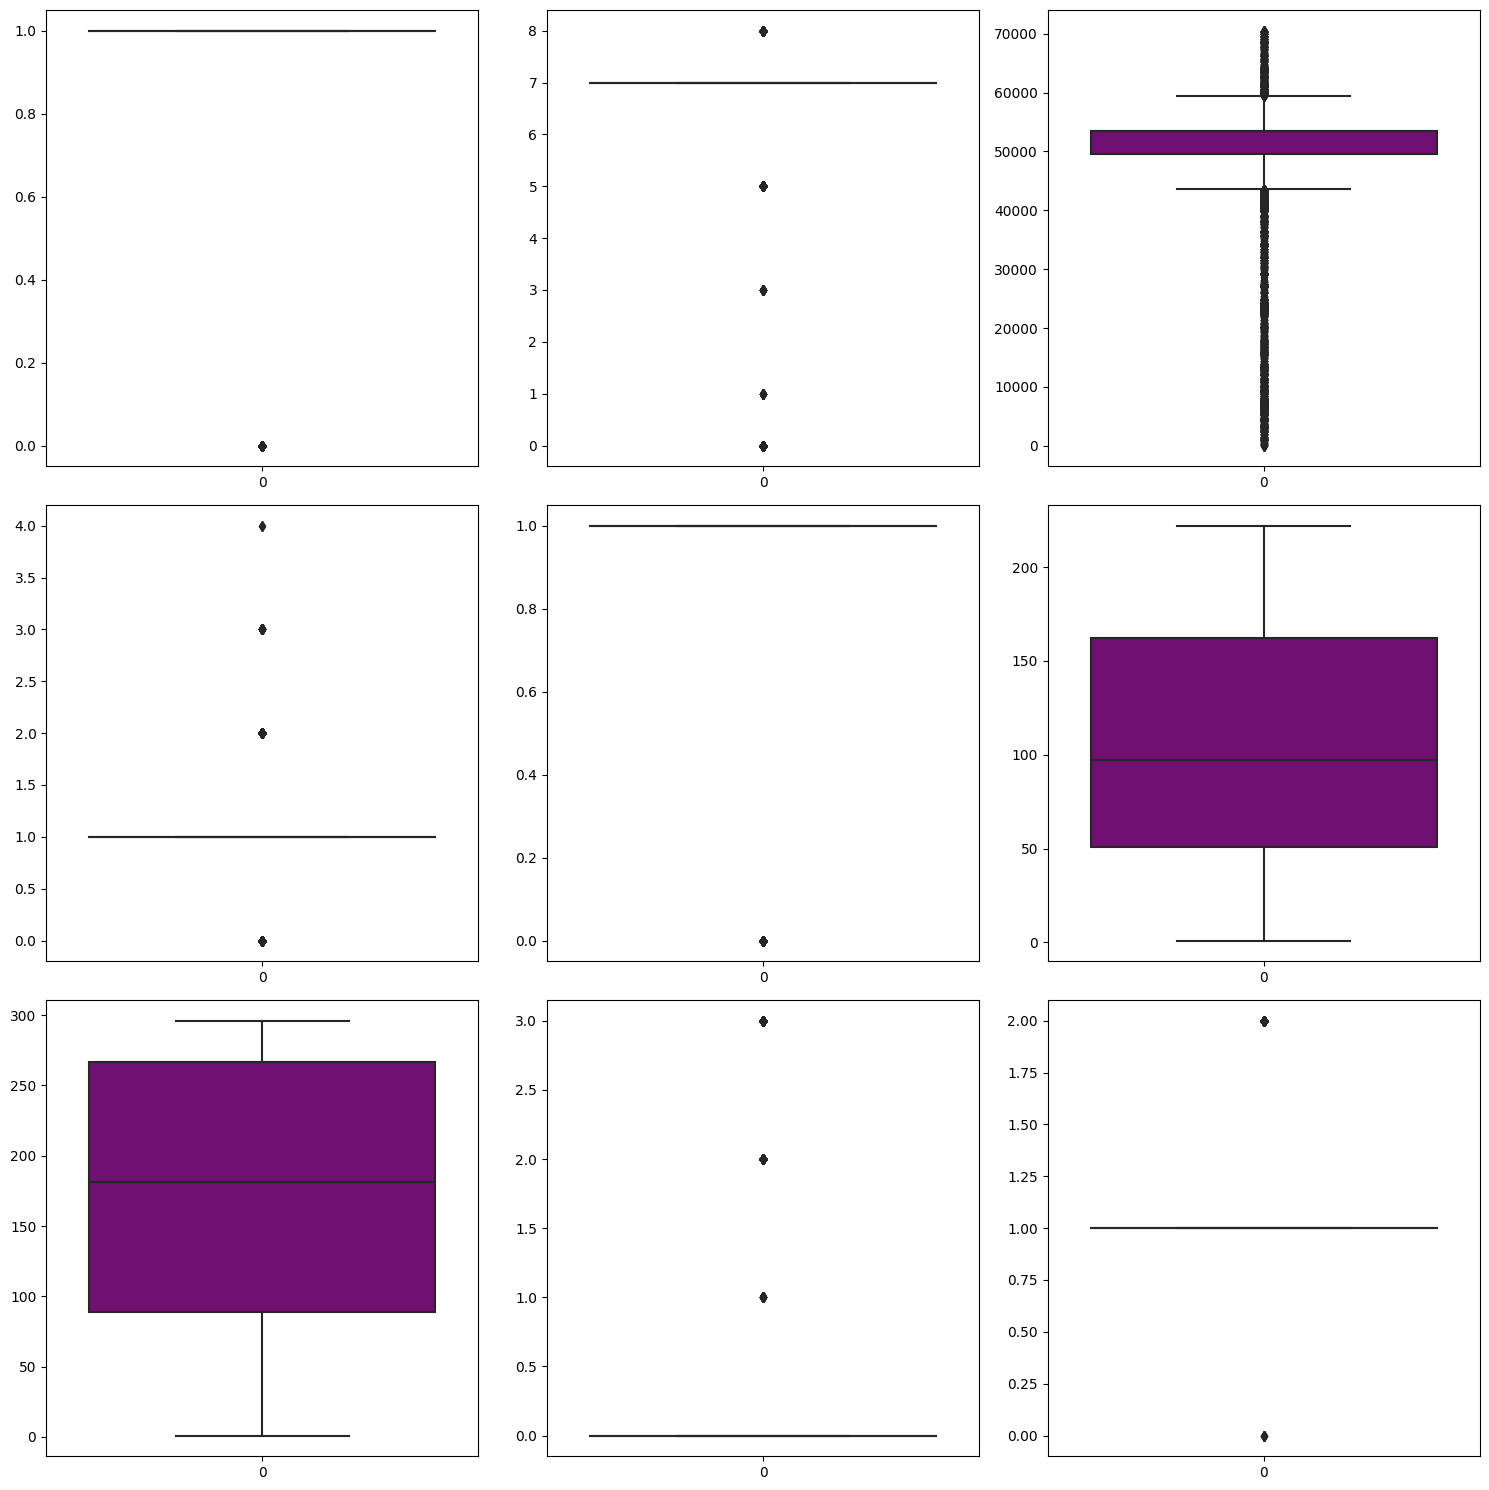

In [32]:
fig, ax = plt.subplots(3,3,figsize=(15,15))
for i, subplot in zip(numerical_cols,ax.flatten()):
    sns.boxplot(train_data[i],ax=subplot,color='Purple')
plt.tight_layout()
plt.show()

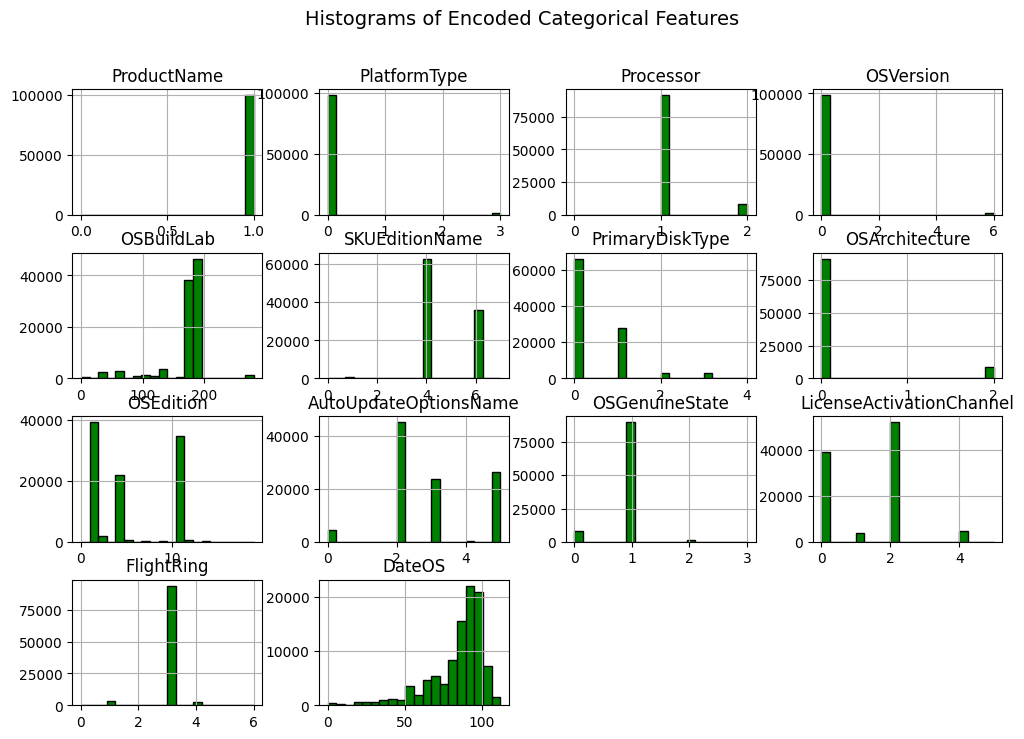

In [33]:
encoded_cols = ['ProductName', 'PlatformType', 'Processor', 'OSVersion', 'OSBuildLab',
       'SKUEditionName', 'PrimaryDiskType', 'OSArchitecture', 'OSEdition',
       'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel',
       'FlightRing', 'DateOS']
train_data[encoded_cols].hist(figsize=(12, 8), bins=20, color="green", edgecolor="black")
plt.suptitle("Histograms of Encoded Categorical Features", fontsize=14)
plt.show()

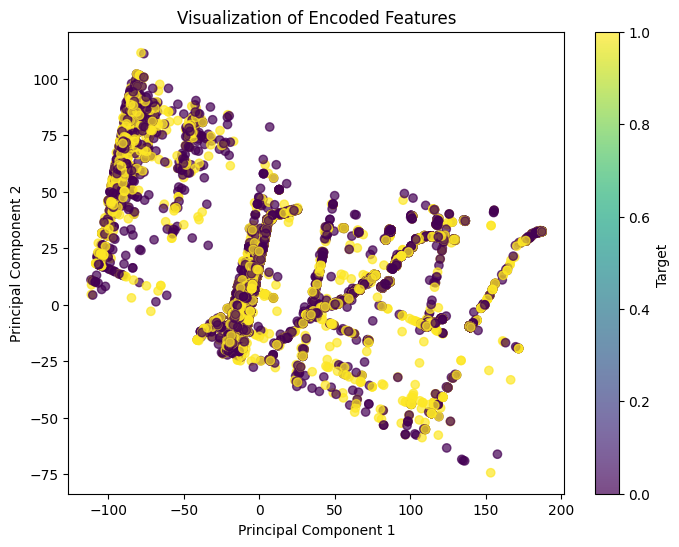

In [34]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(train_data[encoded_cols])

plt.figure(figsize=(8, 6))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=train_data["target"], cmap="viridis", alpha=0.7) 
plt.colorbar(label="Target ")
plt.title("Visualization of Encoded Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Preprocessing 
Scaling the numerical features and encoding the categorical features

In [35]:
X = train_data.drop('target', axis=1)  
y = train_data['target']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder())  
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_transformed = preprocessor.fit_transform(X)
test_data=preprocessor.transform(test_data)

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, shuffle=True)

**Creating a dataframe to perform feature selection from the transformed data.**

In [36]:
all_cols = numerical_cols + categorical_cols
X_transformed = pd.DataFrame(X_transformed, columns=all_cols)
X_transformed.shape

(100000, 35)

# Feature Selection
Selecting the features which are most relevant ones.

In [37]:
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X_transformed.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['RealTimeProtectionState', 'AntivirusConfigID', 'Processor',
       'IsSystemProtected', 'ProcessorCoreCount', 'TotalPhysicalRAMMB',
       'OSArchitecture', 'IsAlwaysOnAlwaysConnectedCapable', 'AppVerNum',
       'EngineVerNum'],
      dtype='object')


In [38]:
selected_columns = ['RealTimeProtectionState', 'AntivirusConfigID', 'Processor',
       'IsSystemProtected', 'ProcessorCoreCount', 'TotalPhysicalRAMMB',
       'OSArchitecture', 'IsAlwaysOnAlwaysConnectedCapable', 'AppVerNum',
       'EngineVerNum']
new_df = train_data[selected_columns]

# Model Building
Finding out the best parameters for the model to be build for better evaluation

In [39]:
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
}

param_distributions = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

best_models = {}
for name, model in models.items():
    random_search = RandomizedSearchCV(model, param_distributions=param_distributions[name], n_iter=10, cv=5, verbose=2, n_jobs=-1)
    random_search.fit(X_transformed, y)
    best_models[name] = random_search.best_estimator_
    print(f"Best Params for {name}: {random_search.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params for RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params for LogisticRegression: {'solver': 'lbfgs', 'C': 10}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params for DecisionTree: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}


# Model Training
The models to be trained according to the parameters are :

**1. Random forest
2. Logistic Regression
3. Decision Tree
4. Adaboost
5. XG Boost**


In [45]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_depth=20, random_state=42)
rf_model.fit(X_transformed, y)
rf_pred1 = rf_model.predict(test_data)
rf_pred=rf_model.predict(X_test)
rf_acc = accuracy_score(y_test,rf_pred)
print(len(rf_pred1))
print(f"RandomForest Accuracy: {rf_acc:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


10000
RandomForest Accuracy: 0.7713


In [32]:
lr_model = LogisticRegression(solver='lbfgs', C=1, random_state=42, max_iter=1000)
lr_model.fit(X_transformed, y)
lr_pred1 = lr_model.predict(test_data)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(len(lr_pred1))
print(f"LogisticRegression Accuracy: {lr_accuracy:.4f}")

10000
LogisticRegression Accuracy: 0.5920


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [34]:
dt_model = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=1, max_depth=10, random_state=42)
dt_model.fit(X_transformed, y)
dt_predi1 = dt_model.predict(test_data)
dt_predi = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predi)
print(len(dt_predi1))
print(f"DecisionTreeClassifier Accuracy: {dt_accuracy:.4f}")

10000
DecisionTreeClassifier Accuracy: 0.6234


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [44]:
adaboost_model = AdaBoostClassifier(random_state=42, n_estimators=10, learning_rate=10)
adaboost_model.fit(X_transformed, y)
adaboost_pred = adaboost_model.predict(X_test)
ada_pred=adaboost_model.predict(test_data)
ad_accuracy = accuracy_score(y_test, adaboost_pred)
print(len(ada_pred))
print(f"Adaboost Accuracy: {ad_accuracy:.4f}")

10000
Adaboost Accuracy: 0.5061


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [41]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01]
}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_transformed, y)
best_xgb = xgb_grid.best_estimator_
xgb_pred1 = best_xgb.predict(test_data)
xgb_pred = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"Best XGBoost Params: {xgb_grid.best_params_}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(len(xgb_pred1))

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
XGBoost Accuracy: 0.6232
10000


# Final Model and Submission
Selecting the best performing model and generating the submission file

In [46]:
submission_df = pd.DataFrame({'id': range(0, len(rf_pred1)), 'target': rf_pred1})
submission_df.to_csv('submission.csv', index=False)
print(submission_df.shape)
print("Submission file 'submission.csv' created successfully!")

(10000, 2)
Submission file 'submission.csv' created successfully!
